In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data                          
from bids import BIDSLayout
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix
from nistats.thresholding import map_threshold

### Load task onsets

Load behavioral data containg relevant task onsets. 

In [2]:
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
beh, meta = load_behavioral_data(root=beh_dir)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Query neuroimaging dataset (path extraction)

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `anat_files`: sorted list of preprocessed T1w images
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files
- `mask_files`: brain mask files for fmri sequencnes

In [3]:
bids_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study"

layout = BIDSLayout(
    root=bids_dir,
    derivatives=True,
    validate=True,
    index_metadata=False
)

anat_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "T1w",
    "desc": "preproc",
    "return_type": "filename"
}

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

mask_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "desc": "brain",
    "suffix": "mask",
    "return_type": "filename"
}

anat_files = layout.get(**anat_filter)

fmri_files, conf_files, mask_files = [], [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    mask_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))
    mask_files.append(layout.get(**mask_filter))

### Single subject analysis

Here, first level GLM analysis is performed for each subject. For each imaging sequence following steps are applied:
1. relevant files are loaded: anatomical, functional, brain mask for functional file
2. `events` DataFrame containing left and right button presses (and misses) events is created. Event onset is assumed to be decision phase onset shifted by response time of participant. Button press events are modeled as zero-duration impulses
3. `confounds` dataframe is loaded and filtered. Included confounds are: six motion parameters and first five a_comp_cor regressors
4. glm model is evaluated (beta estimates for all regressors)
5. contrast of interest is defined. Here, contrast of interest, `left_minus_right`, is the difference between left button press and right button press events.
6. statistical t-map is calculated for defined contrast and saved under BIDS-like name in `bids_dir/derivatives/nistats/buttonpress` directory

In [5]:
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/buttonpress"

# Specify GLM
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model='ar1',
    drift_model='cosine',
    period_cut=128,
    standardize=False,
    hrf_model='spm',
    smoothing_fwhm=6)

In [ ]:
for sub_idx in range(n_subjects):

    print(f"Analyzing sub-{meta['dim1'][sub_idx]}...")
    
    for con_idx in range(n_conditions):

        # Load imaging data
        anat_img = nib.load(anat_files[sub_idx])
        fmri_img = nib.load(fmri_files[con_idx][sub_idx])
        fmri_glm.mask = nib.load(mask_files[0][0])

        # Create onsets representing button presses
        resp_onset = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_dec')] + \
                     beh[sub_idx, con_idx, :, meta['dim4'].index('rt')]
        resp_duration = np.zeros(n_trials)
        resp_type = beh[sub_idx, con_idx, :, 4]

        events_array = np.hstack((resp_onset[:, np.newaxis], 
                                  resp_duration[:, np.newaxis], 
                                  resp_type[:, np.newaxis]))

        events = pd.DataFrame(events_array, columns=['onset', 'duration', 'trial_type'])
        events.loc[events.trial_type == -1, "trial_type"] = "lbp"
        events.loc[events.trial_type ==  0, "trial_type"] = "miss"
        events.loc[events.trial_type ==  1, "trial_type"] = "rbp"

        # Grab and filter confounds
        confounds_relevant = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 
                              'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 
                              'trans_x', 'trans_y', 'trans_z', 
                              'rot_x', 'rot_y', 'rot_z']

        confounds = pd.read_csv(conf_files[con_idx][sub_idx], sep='\t')
        confounds = confounds[confounds_relevant]

        # Fit GLM
        fmri_glm = fmri_glm.fit(
            fmri_img,
            events=events,
            confounds=confounds);

        # Define contrast
        design_matrix = fmri_glm.design_matrices_[0]
        conditions = {
            'lbp': np.zeros(design_matrix.shape[1]),
            'rbp': np.zeros(design_matrix.shape[1]),
        }
        conditions['lbp'][list(design_matrix.columns).index('lbp')] = 1
        conditions['rbp'][list(design_matrix.columns).index('rbp')] = 1
        left_minus_right = conditions['lbp'] - conditions['rbp']

        # Compute statistical map and save it
        z_map = fmri_glm.compute_contrast(
            left_minus_right,
            stat_type='t')

        z_map_fname = f"sub-{meta['dim1'][sub_idx]}_task-prl{meta['dim2'][con_idx]}_desc-buttonpress_tmap"
        nib.save(z_map, os.path.join(out_dir, z_map_fname))

Analyzing sub-m02...


/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:272: RuntimeWarning: invalid value encountered in less
  if (onsets < frame_times[0] + min_onset).any():
/home/kmb/.local/lib/py

Analyzing sub-m03...


/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() 

Analyzing sub-m04...


/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:272: RuntimeWarning: invalid value encountered in less
  if (onsets < frame_times[0] + min_onset).any():
/home/kmb/.local/lib/python3.6/site-packages/nistats/utils.py:262: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been depre

Analyzing sub-m05...


/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/kmb/.local/lib/python3.6/site-packages/nistats/utils.py:262: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None

Analyzing sub-m06...


/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/kmb/.local/lib/python3.6/site-packages/nistats/hemodynamic_models.py:272: RuntimeWarning: invalid value encountered in less
  if (onsets < frame_times[0] + min_onset).any():
/home/kmb/.local/lib/python3.6/site-packages/nistats/utils.py:262: UserWarning: Matrix is singular at working precision, regularizing...
  warn('Matrix is singular at working precision, regularizing...')
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been depre

/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


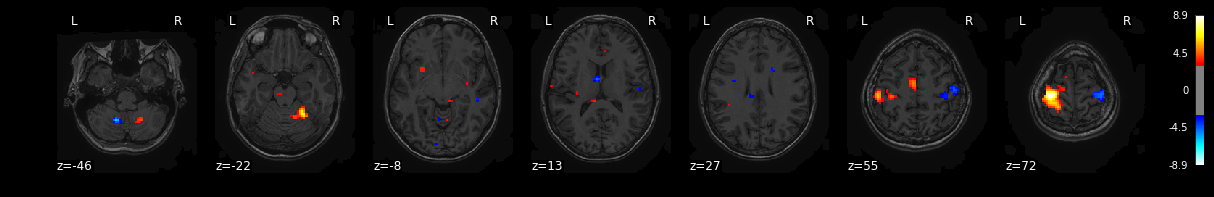

In [28]:
# (optional) Display first-level results in the brain space
_, threshold = map_threshold(
    z_map, 
    level=.05, 
    height_control='fpr')

plot_stat_map(
    z_map, 
    bg_img=anat_img,
    threshold=3,
    display_mode='z')